In [1]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import mat_neuron.core as matmodel

# plotting packages
%matplotlib inline
import matplotlib.pyplot as plt # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

/home/dmeliza/.virtualenvs/akit/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [42]:
# model parameters
matparams = np.asarray([100, 2, -0.3, 7, 15, 10, 10, 200, 5, 2], dtype='d')
# these parameters should be slightly better but produce same output
# matparams = np.asarray([9.27063294,   1.77843253,  -0.29152392,   6.26916095,  13.37407994,
#                        10, 10, 200, 5, 2], dtype='d')
matstate = np.zeros(6, dtype='d')
model_dt = 0.5

# data parameters
duration = 20000
n_samples = int(duration / model_dt)
n_assim = 2
n_test = 0

# assimilation parameters
nthreads = 8
nwalkers = 4000
nsteps = 1000
matparams_i = [0,1,2,3,5]
matparams_n = len(matparams_i)
matparams_f = matparams[matparams_i]

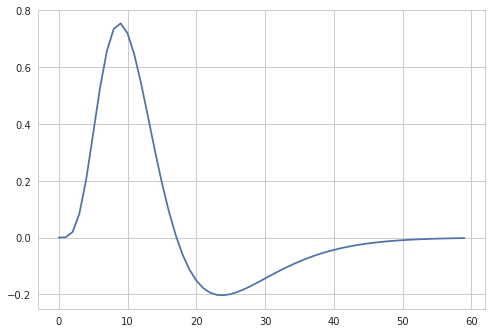

In [45]:
# convolution - simple alpha kernel
from scipy.signal import resample
stim_dt = 10.0

# alpha filter
tau_h = 50
tt = np.arange(0, 600, stim_dt)
k1 = tt / tau_h * np.exp(-tt / tau_h)

# difference of gammas:
from scipy.special import gamma
tau_h1 = 600. / 32
tau_h2 = 600. / 16
kg1 = 1/(gamma(6)*tau_h1)*(tt/tau_h1)**5 * np.exp(-tt/tau_h1)
kg2 = 1/(gamma(6)*tau_h2)*(tt/tau_h2)**5 * np.exp(-tt/tau_h2)
k1 = (kg1 - kg2 / 1.5)
k1 /= np.linalg.norm(k1) / 2

# this is slow, but should work as proof of principle
def filter_stimulus(S, k1):
    return resample(np.convolve(S, k1, mode="same"), n_samples)
plt.plot(k1)

In [46]:
# generate data to fit
np.random.seed(1)
matmodel.random_seed(1)
data = []
stim = np.random.randn(int(n_samples / (stim_dt / model_dt)))
I = filter_stimulus(stim, k1)
#I = np.random.randn(n_samples)
for i in range(n_assim + n_test):
    states, spikes = matmodel.predict(matstate, matparams, I, model_dt, stochastic=True)
    z = matmodel.spike_array(spikes, n_samples)
    d = {"I_stim": I,
         "duration": duration,
         "states": states,
         "spike_t": np.asarray(spikes),
         "spike_v": z,
         "lci": matmodel.log_intensity(matstate, matparams, I, z, model_dt)
         }
    data.append(d)

# split into assimilation and test sets
assim_data = data[:n_assim]
test_data = data[n_assim:]

390

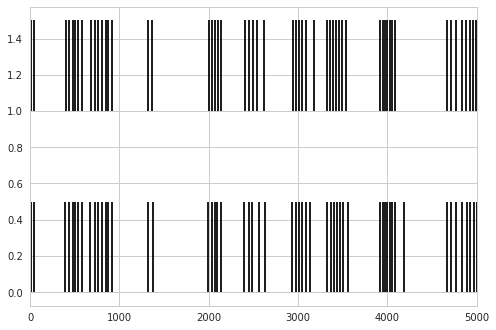

In [47]:
for i, d in enumerate(data):
    plt.vlines(d["spike_t"], i, i + 0.5)
plt.xlim([0, 5000])
len(data[0]["spike_t"])

In [48]:
# estimate parameters using emcee
from neurofit import priors, costs, utils, startpos
import emcee

mat_prior = priors.joint_independent(
                [ priors.uniform(-50,  200),
                  priors.uniform(-5,   10),
                  priors.uniform(-5,   5),
                  priors.uniform( 0,  20),
                  priors.uniform( 5,  20),
                ])

# lasso prior on RF parameters
rf_lambda = 1.0
def rf_prior(theta):
    return -np.sum(np.abs(theta)) * rf_lambda

# this is the local copy of the parameters that we'll update in each step
mparams = matparams.copy()
rfparams = k1.copy()

def lnpost_dyn(theta):
    """Posterior probability for dynamical parameters"""
    from mat_neuron._model import log_intensity
    mparams[matparams_i] = theta[:matparams_n]
    rfparams[:] = theta[matparams_n:]    
    ll = mat_prior(theta[:matparams_n]) + rf_prior(rfparams)
    if not np.isfinite(ll):
        return -np.inf
    # precalculate impulse matrix - this is affected by beta, so it has to be in here
    Aexp = matmodel.impulse_matrix(mparams, model_dt, reduced=False)
    lp = 0
    I = filter_stimulus(stim, rfparams)
    for d in assim_data:
        lci = log_intensity(matstate, Aexp, mparams, I, d["spike_v"], model_dt)
        # NB: if you get overflow errors, adjust bounds to keep lci in a reasonable range (like -100 to 100)        
        if (lci > 40).any():
            return -np.inf
        lpq = np.sum(lci[d["spike_t"]]) - model_dt * np.sum(np.exp(lci))
        lp += lpq
    return ll + lp        

In [50]:
# theoretically this is as good as it can get
theta_true = np.concatenate([matparams_f, k1])
print(lnpost_dyn(theta_true))
# and this is our initial state
startparams = np.asarray([[-50,-5,-5,0,5],[200,10,5,20,20]]).T
p0 = np.concatenate([startpos.uniform_independent(nwalkers, startparams[:,0], startparams[:,1]),
                     startpos.normal_independent(nwalkers, k1, [0.1] * k1.size)],
                   axis=1)
print(lnpost_dyn(np.median(p0, 0)))

-1151.02528731
-91275.5973008


In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, matparams_f.size, lnpost_dyn, threads=nthreads)
tracker = utils.convergence_tracker(nsteps, 25)

for pos, prob, _ in tracker(sampler.sample(p0, iterations=nsteps, storechain=False)): 
    continue

  step      lnprob        time         ETA
------------------------------------------


/home/dmeliza/.virtualenvs/akit/lib/python3.4/site-packages/emcee-2.2.1-py3.4.egg/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
/home/dmeliza/.virtualenvs/akit/lib/python3.4/site-packages/emcee-2.2.1-py3.4.egg/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater


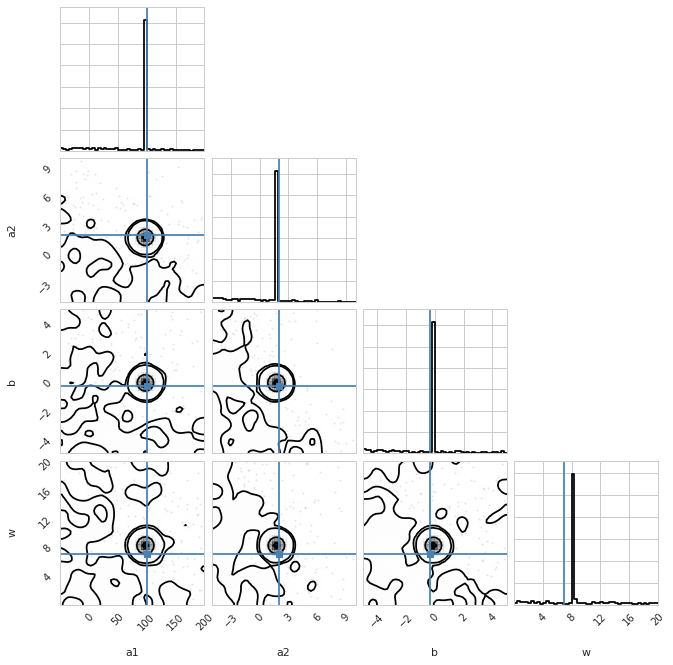

In [34]:
from corner import corner
sns.set_style("whitegrid")

mpos = pos[:,:matparams_n]
matlabs = ['a1','a2','b','w', 'R']
c = corner(mpos,
           range=[sp for sp in startparams],
       bins=50, smooth=2,smooth1d=0,
       labels=matlabs,
       truths=matparams_f)

[ 100.     2.    -0.3    7. ]
[ 98.72443961   1.71369165  -0.1799551    8.32614073]


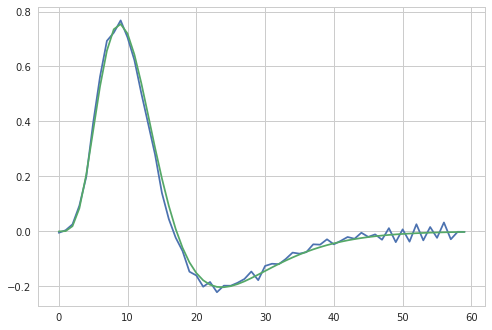

In [35]:
theta = np.median(pos, 0)
mparams[matparams_i] = theta[:matparams_n]
rfparams[:] = theta[matparams_n:]
plt.plot(rfparams)
plt.plot(k1)
print(matparams_f)
print(theta[:matparams_n])

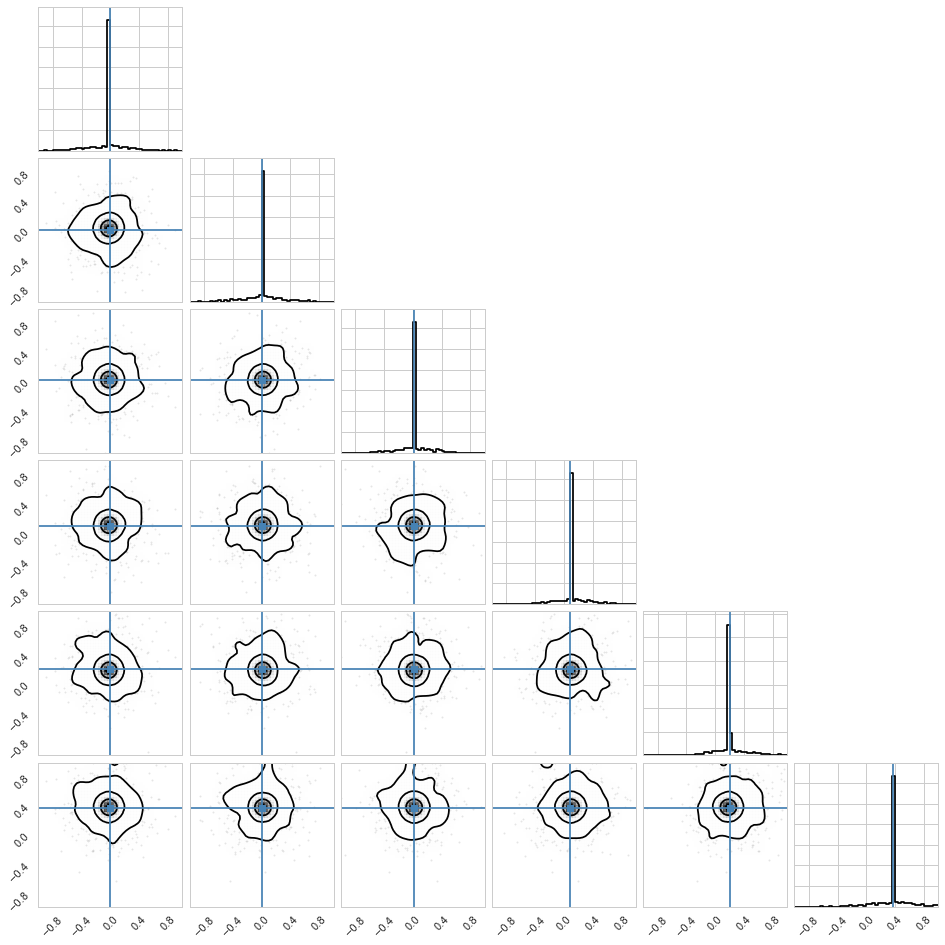

In [36]:
rpos = pos[:,matparams_n:]
c = corner(rpos[:,:6],
           range=[[-1, 1] for i in range(6)],
           bins=50, smooth=2,smooth1d=0,
           truths=k1[:6])

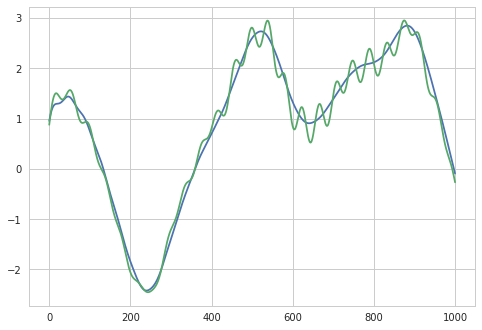

In [37]:
# see how well predictions line up
d = assim_data[0]

I = filter_stimulus(stim, rfparams)
plt.plot(d["I_stim"][:1000])
plt.plot(I[:1000])

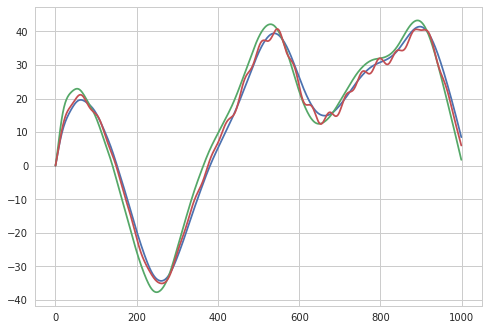

In [38]:
Y, S = matmodel.predict(matstate, mparams, I, model_dt, stochastic=True)
plt.plot(d["states"][:1000,0])
plt.plot(d["states"][:1000,0] - d["states"][:1000,4])
plt.plot(Y[:1000,0])

(386, 390)

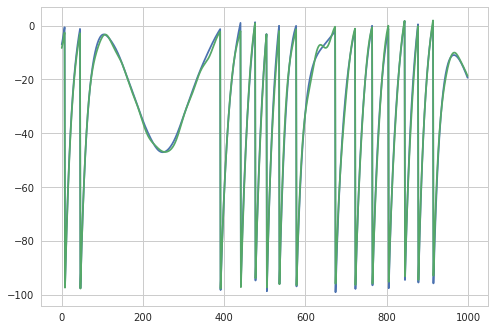

In [39]:
lci_guess = matmodel.log_intensity(matstate, mparams, I, d["spike_v"], model_dt)
plt.plot(d["lci"][:1000])
plt.plot(lci_guess[:1000])
(len(S), len(d["spike_t"]))

In [40]:
(d["lci"] - lci_guess).mean()

0.018612826236133834